In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model
from keras import layers
from keras.callbacks import EarlyStopping
import tensorflow as tf
import sklearn, os


from mpl_toolkits import mplot3d

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}

ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])
df['T0'] = np.cos(df.time.dt.dayofyear * 2 * np.pi/365)
df['T1'] = np.sin(df.time.dt.dayofyear * 2 * np.pi/365)

df.drop(columns=['xlon', 'ylat', 'time', 'TLONG', 'TLAT'], inplace=True)

df['pCO2'] = df.pop('pCO2')
df.head()

,XCO2,SST,SSS,MLD,Chl,A,B,C,T0,T1,pCO2
20,340.848541,-1.552322,33.641834,12.729663,1.128493,-0.375524,0.444338,-0.813355,0.962309,0.271958,256.390077
21,340.848541,-1.626047,33.667816,19.951666,0.900315,0.576990,0.391571,-0.716767,0.962309,0.271958,262.338616
22,340.848541,-1.607591,33.572289,19.510101,0.635458,0.999021,-0.021204,0.038813,0.962309,0.271958,261.956626
23,340.848541,-1.496069,33.424641,20.714338,0.420227,0.502557,-0.414484,0.758709,0.962309,0.271958,262.739347
24,340.848541,-1.207762,33.317802,20.579535,0.380468,-0.455956,-0.426690,0.781051,0.962309,0.271958,266.288585


In [4]:
values = df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14785200, 10) (14785200,) (2505270, 10) (2505270,)


## Baseline Feedforward Neural Network

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

In [7]:
history = model.fit(train_X, train_y, epochs=100, batch_size=1024, validation_data=(test_X, test_y))

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/100
14785200/14785200 [==============================] - 120s 8us/step - loss: 861.8007 - mean_squared_error: 861.8007 - val_loss: 732.2238 - val_mean_squared_error: 732.2238
Epoch 2/100
14785200/14785200 [==============================] - 119s 8us/step - loss: 645.5460 - mean_squared_error: 645.5460 - val_loss: 628.1847 - val_mean_squared_error: 628.1847
Epoch 3/100
14785200/14785200 [==============================] - 121s 8us/step - loss: 559.8103 - mean_squared_error: 559.8103 - val_loss: 573.5782 - val_mean_squared_error: 573.5782
Epoch 4/100
14785200/14785200 [==============================] - 120s 8us/step - loss: 499.6409 - mean_squared_error: 499.6409 - val_loss: 537.3167 - val_mean_squared_error: 537.3167
Epoch 5/100
14785200/14785200 [==============================] - 120s 8us/step - loss: 469.0201 - mean_squared_error: 469.0201 - val_loss: 517.5426 - val_mean_squared_error: 517.5426
Epoch 6/100
14785200/14785200 

14785200/14785200 [==============================] - 118s 8us/step - loss: 275.4299 - mean_squared_error: 275.4299 - val_loss: 329.0726 - val_mean_squared_error: 329.0726
Epoch 90/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 275.1164 - mean_squared_error: 275.1164 - val_loss: 354.2044 - val_mean_squared_error: 354.2044
Epoch 91/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 275.0030 - mean_squared_error: 275.0030 - val_loss: 348.5294 - val_mean_squared_error: 348.5294
Epoch 92/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 274.9372 - mean_squared_error: 274.9372 - val_loss: 341.1953 - val_mean_squared_error: 341.1953
Epoch 93/100
14785200/14785200 [==============================] - 117s 8us/step - loss: 274.7636 - mean_squared_error: 274.7636 - val_loss: 325.9420 - val_mean_squared_error: 325.9420
Epoch 94/100
14785200/14785200 [==============================] - 116s 8us/step - loss: 274.6

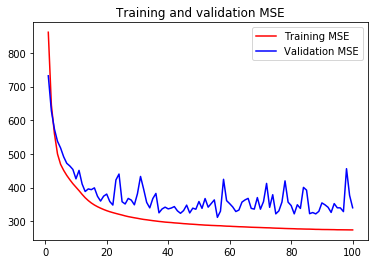

In [8]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

In [11]:
model.save_weights('baseline_DNN.h5')

## SOM Clusters as Input to FFN

In [4]:
SOM_df = pd.read_csv('means_SOM.csv', index_col=0)

SOM_df['A'], SOM_df['B'], SOM_df['C'] = np.sin(SOM_df['ylat']), np.sin(SOM_df['xlon'])*np.cos(SOM_df['ylat']), -np.cos(SOM_df['xlon'])*np.cos(SOM_df['ylat'])
SOM_df.drop(columns=['ylat', 'xlon'], inplace=True)

SOM_df['pCO2'] = SOM_df.pop('pCO2')
SOM_df.head()

,SSS,MLD,SST,k=5,k=10,k=15,A,B,C,pCO2
0,34.316242,5.469693,-1.257135,3,9,4,-0.862311,0.210735,-0.460446,270.162289
1,34.295708,5.467124,-1.274530,3,9,4,-0.862311,0.501312,-0.071453,269.626504
2,34.269802,5.456498,-1.300513,3,9,4,-0.862311,0.330985,0.383234,268.901123
3,34.241173,5.422664,-1.334906,3,9,4,-0.862311,-0.143648,0.485577,268.001064
4,34.213009,5.353684,-1.375007,3,9,4,-0.862311,-0.486212,0.141483,266.963243


In [5]:
def train_test_split_SOM(df, num_clusters, test_split=0.2):
    if num_clusters == 5:
        df_cluster = df.drop(columns=['k=10', 'k=15'])
    elif num_clusters == 10:
        df_cluster = df.drop(columns=['k=5', 'k=15'])
    else:
        df_cluster = df.drop(columns=['k=5', 'k=10'])

    cluster_type = df_cluster.columns[3]
    # creating a unique dataframe for each cluster
    df_dict = {}
    for k in df_cluster[cluster_type].unique():
        df_dict['df{0}'.format(k)] = df_cluster[df_cluster[cluster_type] == k].drop(columns=cluster_type)

    # creating a unique feature and target matrix for each cluster
    X_dict, y_dict = {}, {}
    for key, value in df_dict.items():
        X_dict['X{0}'.format(key[-1])] = value.values[:, :-1]
        y_dict['y{0}'.format(key[-1])] = value.values[:, -1:]

    # creating a unique train/test split for each feature/target mapping
    train_X_dict, test_X_dict, train_y_dict, test_y_dict = {}, {}, {}, {}
    for i in range(0, num_clusters):
        train_X_dict[i], test_X_dict[i], train_y_dict[i], test_y_dict[i] = train_test_split(X_dict['X{0}'.format(i)], y_dict['y{0}'.format(i)], test_size=test_split, shuffle=False)
        
    return train_X_dict, test_X_dict, train_y_dict, test_y_dict

train_X, test_X, train_y, test_y = train_test_split_SOM(SOM_df, 5)

In [9]:
input_0 = layers.Input(shape=(train_X[0].shape[1],), name='input_0')
branch_0 = layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal')(input_0)
branch_0 = layers.Dropout(0.4)(input_0)
branch_0 = layers.Dense(512, activation='relu', kernel_initializer='glorot_normal')(input_0)
branch_0 = layers.Dropout(0.4)(input_0)
branch_0 = layers.Dense(1, kernel_initializer='glorot_normal')(branch_0)


input_1 = layers.Input(shape=(train_X[1].shape[1],), name='input_1')
branch_1 = layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal')(input_1)
branch_1 = layers.Dropout(0.4)(input_1)
branch_1 = layers.Dense(512, activation='relu', kernel_initializer='glorot_normal')(input_1)
branch_1 = layers.Dropout(0.4)(input_1)
branch_1 = layers.Dense(1, kernel_initializer='glorot_normal')(branch_1)


input_2 = layers.Input(shape=(train_X[2].shape[1],), name='input_2')
branch_2 = layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal')(input_2)
branch_2 = layers.Dropout(0.4)(input_2)
branch_2 = layers.Dense(512, activation='relu', kernel_initializer='glorot_normal')(input_2)
branch_2 = layers.Dropout(0.4)(input_2)
branch_2 = layers.Dense(1, kernel_initializer='glorot_normal')(branch_2)


input_3 = layers.Input(shape=(train_X[3].shape[1],), name='input_3')
branch_3 = layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal')(input_3)
branch_3 = layers.Dropout(0.4)(input_3)
branch_3 = layers.Dense(512, activation='relu', kernel_initializer='glorot_normal')(input_3)
branch_3 = layers.Dropout(0.4)(input_3)
branch_3 = layers.Dense(1, kernel_initializer='glorot_normal')(branch_3)


input_4 = layers.Input(shape=(train_X[4].shape[1],), name='input_4')
branch_4 = layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal')(input_4)
branch_4 = layers.Dropout(0.4)(input_4)
branch_4 = layers.Dense(512, activation='relu', kernel_initializer='glorot_normal')(input_4)
branch_4 = layers.Dropout(0.4)(input_4)
branch_4 = layers.Dense(1, kernel_initializer='glorot_normal')(branch_4)

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

In [11]:
model_0 = Model(inputs=[input_0], outputs=[branch_0])
model_0.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_1 = Model(inputs=[input_1], outputs=[branch_1])
model_1.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_2 = Model(inputs=[input_2], outputs=[branch_2])
model_2.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_3 = Model(inputs=[input_3], outputs=[branch_3])
model_3.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_4 = Model(inputs=[input_4], outputs=[branch_4])
model_4.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [49]:
history_0 = model_0.fit([train_X[0]], [train_y[0]], validation_data=(test_X[0], test_y[0]), epochs=200)
history_1 = model_1.fit([train_X[1]], [train_y[1]], validation_data=(test_X[1], test_y[1]), epochs=200)
history_2 = model_2.fit([train_X[2]], [train_y[2]], validation_data=(test_X[2], test_y[2]), epochs=600)
history_3 = model_3.fit([train_X[3]], [train_y[3]], validation_data=(test_X[3], test_y[3]), epochs=200)
history_4 = model_4.fit([train_X[4]], [train_y[4]], validation_data=(test_X[4], test_y[4]), epochs=200)

Train on 1264 samples, validate on 316 samples
Epoch 1/600
1264/1264 [==============================] - 0s 100us/step - loss: 4674.7689 - mean_squared_error: 4674.7689 - val_loss: 369.0277 - val_mean_squared_error: 369.0277
Epoch 2/600
1264/1264 [==============================] - 0s 97us/step - loss: 4754.1433 - mean_squared_error: 4754.1433 - val_loss: 366.8603 - val_mean_squared_error: 366.8603
Epoch 3/600
1264/1264 [==============================] - 0s 98us/step - loss: 4955.8840 - mean_squared_error: 4955.8840 - val_loss: 366.6320 - val_mean_squared_error: 366.6320
Epoch 4/600
1264/1264 [==============================] - 0s 99us/step - loss: 4548.1006 - mean_squared_error: 4548.1006 - val_loss: 367.1998 - val_mean_squared_error: 367.1998
Epoch 5/600
1264/1264 [==============================] - 0s 96us/step - loss: 4654.6236 - mean_squared_error: 4654.6236 - val_loss: 366.5147 - val_mean_squared_error: 366.5147
Epoch 6/600
1264/1264 [==============================] - 0s 98us/step - 

Epoch 47/600
1264/1264 [==============================] - 0s 100us/step - loss: 4759.4675 - mean_squared_error: 4759.4675 - val_loss: 356.3779 - val_mean_squared_error: 356.3779
Epoch 48/600
1264/1264 [==============================] - 0s 102us/step - loss: 4505.8611 - mean_squared_error: 4505.8611 - val_loss: 353.5611 - val_mean_squared_error: 353.5611
Epoch 49/600
1264/1264 [==============================] - 0s 97us/step - loss: 4729.1496 - mean_squared_error: 4729.1496 - val_loss: 352.7062 - val_mean_squared_error: 352.7062
Epoch 50/600
1264/1264 [==============================] - 0s 100us/step - loss: 4666.3501 - mean_squared_error: 4666.3501 - val_loss: 355.5590 - val_mean_squared_error: 355.5590
Epoch 51/600
1264/1264 [==============================] - 0s 98us/step - loss: 4548.6850 - mean_squared_error: 4548.6850 - val_loss: 357.5350 - val_mean_squared_error: 357.5350
Epoch 52/600
1264/1264 [==============================] - 0s 99us/step - loss: 4690.3689 - mean_squared_error: 4

Epoch 139/600
1264/1264 [==============================] - 0s 96us/step - loss: 4590.7103 - mean_squared_error: 4590.7103 - val_loss: 341.9474 - val_mean_squared_error: 341.9474
Epoch 140/600
1264/1264 [==============================] - 0s 98us/step - loss: 4562.0953 - mean_squared_error: 4562.0953 - val_loss: 342.2500 - val_mean_squared_error: 342.2500
Epoch 141/600
1264/1264 [==============================] - 0s 98us/step - loss: 4347.5754 - mean_squared_error: 4347.5754 - val_loss: 341.7045 - val_mean_squared_error: 341.7045
Epoch 142/600
1264/1264 [==============================] - 0s 96us/step - loss: 4506.4208 - mean_squared_error: 4506.4208 - val_loss: 341.8193 - val_mean_squared_error: 341.8193
Epoch 143/600
1264/1264 [==============================] - 0s 97us/step - loss: 4270.8807 - mean_squared_error: 4270.8807 - val_loss: 341.5619 - val_mean_squared_error: 341.5619
Epoch 144/600
1264/1264 [==============================] - 0s 98us/step - loss: 4312.8774 - mean_squared_error

Epoch 185/600
1264/1264 [==============================] - 0s 97us/step - loss: 4423.3457 - mean_squared_error: 4423.3457 - val_loss: 338.4429 - val_mean_squared_error: 338.4429
Epoch 186/600
1264/1264 [==============================] - 0s 97us/step - loss: 4491.6086 - mean_squared_error: 4491.6086 - val_loss: 337.7351 - val_mean_squared_error: 337.7351
Epoch 187/600
1264/1264 [==============================] - 0s 98us/step - loss: 4314.2950 - mean_squared_error: 4314.2950 - val_loss: 336.2576 - val_mean_squared_error: 336.2576
Epoch 188/600
1264/1264 [==============================] - 0s 100us/step - loss: 4330.0853 - mean_squared_error: 4330.0853 - val_loss: 335.6802 - val_mean_squared_error: 335.6802
Epoch 189/600
1264/1264 [==============================] - 0s 100us/step - loss: 4353.8905 - mean_squared_error: 4353.8905 - val_loss: 335.4645 - val_mean_squared_error: 335.4645
Epoch 190/600
1264/1264 [==============================] - 0s 101us/step - loss: 4407.8628 - mean_squared_er

Epoch 231/600
1264/1264 [==============================] - 0s 100us/step - loss: 4217.7218 - mean_squared_error: 4217.7218 - val_loss: 334.6834 - val_mean_squared_error: 334.6834
Epoch 232/600
1264/1264 [==============================] - 0s 99us/step - loss: 3999.9772 - mean_squared_error: 3999.9772 - val_loss: 333.0188 - val_mean_squared_error: 333.0188
Epoch 233/600
1264/1264 [==============================] - 0s 97us/step - loss: 4178.2898 - mean_squared_error: 4178.2898 - val_loss: 332.5795 - val_mean_squared_error: 332.5795
Epoch 234/600
1264/1264 [==============================] - 0s 97us/step - loss: 4130.5170 - mean_squared_error: 4130.5170 - val_loss: 332.0092 - val_mean_squared_error: 332.0092
Epoch 235/600
1264/1264 [==============================] - 0s 99us/step - loss: 4259.6191 - mean_squared_error: 4259.6191 - val_loss: 331.1289 - val_mean_squared_error: 331.1289
Epoch 236/600
1264/1264 [==============================] - 0s 98us/step - loss: 4138.1362 - mean_squared_erro

Epoch 277/600
1264/1264 [==============================] - 0s 98us/step - loss: 4144.9955 - mean_squared_error: 4144.9955 - val_loss: 327.5080 - val_mean_squared_error: 327.5080
Epoch 278/600
1264/1264 [==============================] - 0s 99us/step - loss: 4338.2904 - mean_squared_error: 4338.2904 - val_loss: 328.3602 - val_mean_squared_error: 328.3602
Epoch 279/600
1264/1264 [==============================] - 0s 101us/step - loss: 4133.1670 - mean_squared_error: 4133.1670 - val_loss: 328.0060 - val_mean_squared_error: 328.0060
Epoch 280/600
1264/1264 [==============================] - 0s 100us/step - loss: 4077.1033 - mean_squared_error: 4077.1033 - val_loss: 327.2409 - val_mean_squared_error: 327.2409
Epoch 281/600
1264/1264 [==============================] - 0s 100us/step - loss: 4093.4474 - mean_squared_error: 4093.4474 - val_loss: 327.7764 - val_mean_squared_error: 327.7764
Epoch 282/600
1264/1264 [==============================] - 0s 101us/step - loss: 4397.1629 - mean_squared_e

Epoch 323/600
1264/1264 [==============================] - 0s 94us/step - loss: 4329.0626 - mean_squared_error: 4329.0626 - val_loss: 322.6809 - val_mean_squared_error: 322.6809
Epoch 324/600
1264/1264 [==============================] - 0s 99us/step - loss: 4189.5815 - mean_squared_error: 4189.5815 - val_loss: 321.7732 - val_mean_squared_error: 321.7732
Epoch 325/600
1264/1264 [==============================] - 0s 98us/step - loss: 3922.1732 - mean_squared_error: 3922.1732 - val_loss: 321.6078 - val_mean_squared_error: 321.6078
Epoch 326/600
1264/1264 [==============================] - 0s 97us/step - loss: 4196.9402 - mean_squared_error: 4196.9402 - val_loss: 322.0588 - val_mean_squared_error: 322.0588
Epoch 327/600
1264/1264 [==============================] - 0s 98us/step - loss: 3953.3655 - mean_squared_error: 3953.3655 - val_loss: 321.6420 - val_mean_squared_error: 321.6420
Epoch 328/600
1264/1264 [==============================] - 0s 100us/step - loss: 4298.0927 - mean_squared_erro

Epoch 369/600
1264/1264 [==============================] - 0s 98us/step - loss: 4109.3394 - mean_squared_error: 4109.3394 - val_loss: 316.7888 - val_mean_squared_error: 316.7888
Epoch 370/600
1264/1264 [==============================] - 0s 100us/step - loss: 4106.8751 - mean_squared_error: 4106.8751 - val_loss: 316.8321 - val_mean_squared_error: 316.8321
Epoch 371/600
1264/1264 [==============================] - 0s 98us/step - loss: 3915.6172 - mean_squared_error: 3915.6172 - val_loss: 316.8226 - val_mean_squared_error: 316.8226
Epoch 372/600
1264/1264 [==============================] - 0s 97us/step - loss: 3848.7876 - mean_squared_error: 3848.7876 - val_loss: 316.7775 - val_mean_squared_error: 316.7775
Epoch 373/600
1264/1264 [==============================] - 0s 97us/step - loss: 4041.1353 - mean_squared_error: 4041.1353 - val_loss: 316.9910 - val_mean_squared_error: 316.9910
Epoch 374/600
1264/1264 [==============================] - 0s 98us/step - loss: 4051.2973 - mean_squared_erro

Epoch 415/600
1264/1264 [==============================] - 0s 98us/step - loss: 3910.0820 - mean_squared_error: 3910.0820 - val_loss: 313.4631 - val_mean_squared_error: 313.4631
Epoch 416/600
1264/1264 [==============================] - 0s 102us/step - loss: 3984.6015 - mean_squared_error: 3984.6015 - val_loss: 313.7105 - val_mean_squared_error: 313.7105
Epoch 417/600
1264/1264 [==============================] - 0s 102us/step - loss: 3867.9610 - mean_squared_error: 3867.9610 - val_loss: 313.7210 - val_mean_squared_error: 313.7210
Epoch 418/600
1264/1264 [==============================] - 0s 100us/step - loss: 3830.3135 - mean_squared_error: 3830.3135 - val_loss: 313.3590 - val_mean_squared_error: 313.3590
Epoch 419/600
1264/1264 [==============================] - 0s 102us/step - loss: 3950.7897 - mean_squared_error: 3950.7897 - val_loss: 312.9050 - val_mean_squared_error: 312.9050
Epoch 420/600
1264/1264 [==============================] - 0s 106us/step - loss: 3775.3356 - mean_squared_

Epoch 461/600
1264/1264 [==============================] - 0s 98us/step - loss: 3918.4590 - mean_squared_error: 3918.4590 - val_loss: 310.5176 - val_mean_squared_error: 310.5176
Epoch 462/600
1264/1264 [==============================] - 0s 98us/step - loss: 3850.6523 - mean_squared_error: 3850.6523 - val_loss: 310.4123 - val_mean_squared_error: 310.4123
Epoch 463/600
1264/1264 [==============================] - 0s 98us/step - loss: 3939.0981 - mean_squared_error: 3939.0981 - val_loss: 310.2608 - val_mean_squared_error: 310.2608
Epoch 464/600
1264/1264 [==============================] - 0s 99us/step - loss: 3869.7476 - mean_squared_error: 3869.7476 - val_loss: 310.2313 - val_mean_squared_error: 310.2313
Epoch 465/600
1264/1264 [==============================] - 0s 98us/step - loss: 3732.5126 - mean_squared_error: 3732.5126 - val_loss: 310.1384 - val_mean_squared_error: 310.1384
Epoch 466/600
1264/1264 [==============================] - 0s 99us/step - loss: 3988.6209 - mean_squared_error

Epoch 507/600
1264/1264 [==============================] - 0s 98us/step - loss: 3892.2542 - mean_squared_error: 3892.2542 - val_loss: 307.5398 - val_mean_squared_error: 307.5398
Epoch 508/600
1264/1264 [==============================] - 0s 95us/step - loss: 3846.8638 - mean_squared_error: 3846.8638 - val_loss: 307.4799 - val_mean_squared_error: 307.4799
Epoch 509/600
1264/1264 [==============================] - 0s 98us/step - loss: 3887.4945 - mean_squared_error: 3887.4945 - val_loss: 307.3755 - val_mean_squared_error: 307.3755
Epoch 510/600
1264/1264 [==============================] - 0s 97us/step - loss: 3804.6424 - mean_squared_error: 3804.6424 - val_loss: 307.2534 - val_mean_squared_error: 307.2534
Epoch 511/600
1264/1264 [==============================] - 0s 97us/step - loss: 4152.1997 - mean_squared_error: 4152.1997 - val_loss: 307.2033 - val_mean_squared_error: 307.2033
Epoch 512/600
1264/1264 [==============================] - 0s 99us/step - loss: 3626.3140 - mean_squared_error

Epoch 553/600
1264/1264 [==============================] - 0s 98us/step - loss: 3632.1317 - mean_squared_error: 3632.1317 - val_loss: 304.7555 - val_mean_squared_error: 304.7555
Epoch 554/600
1264/1264 [==============================] - 0s 98us/step - loss: 3748.1492 - mean_squared_error: 3748.1492 - val_loss: 304.7039 - val_mean_squared_error: 304.7039
Epoch 555/600
1264/1264 [==============================] - 0s 99us/step - loss: 3672.5978 - mean_squared_error: 3672.5978 - val_loss: 304.5882 - val_mean_squared_error: 304.5882
Epoch 556/600
1264/1264 [==============================] - 0s 96us/step - loss: 3528.9332 - mean_squared_error: 3528.9332 - val_loss: 304.5954 - val_mean_squared_error: 304.5954
Epoch 557/600
1264/1264 [==============================] - 0s 99us/step - loss: 3814.3062 - mean_squared_error: 3814.3062 - val_loss: 304.5906 - val_mean_squared_error: 304.5906
Epoch 558/600
1264/1264 [==============================] - 0s 98us/step - loss: 3761.0001 - mean_squared_error

Epoch 599/600
1264/1264 [==============================] - 0s 100us/step - loss: 3646.5401 - mean_squared_error: 3646.5401 - val_loss: 303.2437 - val_mean_squared_error: 303.2437
Epoch 600/600
1264/1264 [==============================] - 0s 99us/step - loss: 3483.1817 - mean_squared_error: 3483.1817 - val_loss: 303.2680 - val_mean_squared_error: 303.2680


In [50]:
avg_val_mse_0 = np.mean(history_0.history['val_mean_squared_error'][-2:])
avg_val_mse_1 = np.mean(history_1.history['val_mean_squared_error'][-2:])
avg_val_mse_2 = np.mean(history_2.history['val_mean_squared_error'][-2:])
avg_val_mse_3 = np.mean(history_3.history['val_mean_squared_error'][-2:])
avg_val_mse_4 = np.mean(history_4.history['val_mean_squared_error'][-2:])

avg_val_mse = [avg_val_mse_0, avg_val_mse_1, avg_val_mse_2, avg_val_mse_3, avg_val_mse_4]

In [ ]:
total = np.sum([value.shape[0] for key, value in train_X.items()])

In [ ]:
rmse = np.sqrt(np.sum([value.shape[0]*avg_val_mse_2[key] / total for key, value in train_X.items()]))